# Importing libraries

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

In [2]:
#For Dataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# for Dimensionality reduction
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

# for evaluation
from sklearn.metrics import silhouette_score, mean_squared_error

In [3]:
# Colors for visualization

cols = ['#1FC17B', '#78FECF', '#555B6E', '#CC998D', '#429EA6',
        '#153B50', '#8367C7', '#EE6352', '#C287E8', '#F0A6CA', 
        '#521945', '#361F27', '#828489', '#9AD2CB', '#EBD494', 
        '#53599A', '#80DED9', '#EF2D56', '#446DF6', '#AF929D']

# Dataset creation

In [5]:
X, y = make_blobs(n_features = 50, centers = 20, n_samples = 20000,
                 cluster_std = 0.2, center_box = [-1,1], random_state = 17)

In [9]:
print('X: ', X.shape)
print('y: ', y.shape)

X:  (20000, 50)
y:  (20000,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 17)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (18000, 50)
X_test:  (2000, 50)
y_train:  (18000,)
y_test:  (2000,)


# Baseline model: PCA

In [15]:
pca = PCA(n_components=2)
pca.fit(X_train)

res_PCA = pca.transform(X_test)

In [16]:
print('X_test after PCA: ', res_PCA.shape)

X_test after PCA:  (2000, 2)


Unique Lables:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Text(0.5, 1.0, 'PCA Results')

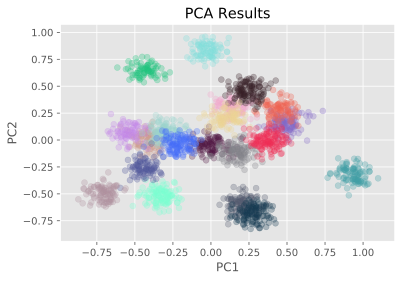

In [20]:
unique_labels = np.unique(y_test)

print("Unique Lables: ", unique_labels)

for index, unique_label in enumerate(unique_labels):
    X_data = res_PCA[y_test == unique_label]
    
    plt.scatter(X_data[:,0], X_data[:,1], alpha = 0.3, c = cols[index])
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Results')

# Autoencoder

In [21]:
autoencoder = MLPRegressor(alpha = 1e-15, 
                           hidden_layer_sizes =(50, 100, 50, 2, 50, 100, 50),
                          random_state = 1, max_iter = 20000)
autoencoder.fit(X_train, X_train)

MLPRegressor(activation='relu', alpha=1e-15, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 100, 50, 2, 50, 100, 50),
             learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
             max_iter=20000, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
             solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# Reducing Dimensionality

In [34]:
W = autoencoder.coefs_
biases = autoencoder.intercepts_

In [35]:
for w in W:
    print(w.shape)

(50, 50)
(50, 100)
(100, 50)
(50, 2)
(2, 50)
(50, 100)
(100, 50)
(50, 50)


In [36]:
encoder_weights = W[0:4]
encoder_biases = biases[0:4]

In [40]:
def encode(encoder_weights, encoder_biases, data):
    res_ae = data
    for index, (w,b) in enumerate(zip(encoder_weights,encoder_biases)):
        # activation will not be applied after final layer of encoding
        if index+1 == len(encoder_weights):
            res_ae = res_ae@w+b
        else:
            res_ae = np.maximum(0, res_ae@w+b) # max(0,x)  is for using relu activation
    return res_ae
res_ae = encode(encoder_weights, encoder_biases, X_test)

In [41]:
res_ae.shape

(2000, 2)

Text(0.5, 1.0, 'Autoencoder Results')

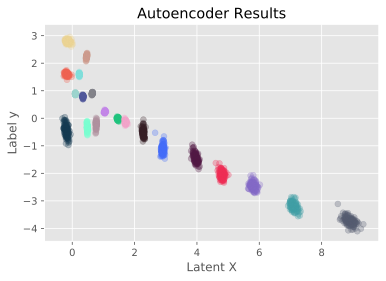

In [43]:
unique_labels = np.unique(y_test)

for index, unique_label in enumerate(unique_labels):
    latent_space = res_ae[y_test == unique_label]
    
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha = 0.3, c=cols[index])
    
plt.xlabel('Latent X')
plt.ylabel('Label y')
plt.title('Autoencoder Results')

# Evaluation

In [44]:
silhouette_score(X_test, y_test)

0.6100948647899368

In [46]:
silhouette_score(res_PCA, y_test)

0.36789164168599664

In [47]:
silhouette_score(res_ae, y_test)

0.8074659601978521

In [50]:
print("Silhouette_score for \n")
print("Original Data:\t", round(silhouette_score(X_test, y_test), 3))
print("PCA:\t\t", round(silhouette_score(res_PCA, y_test), 3))
print("Autoencoder:\t", round(silhouette_score(res_ae, y_test), 3) )

Silhouette_score for 

Original Data:	 0.61
PCA:		 0.368
Autoencoder:	 0.807


<h3>Thus, Autoencoder performs better than PCA.</h3>